# Windfinder
A basic machine learning approch on predicting the pageviews for the windfinder website when provided with weatherdata. 

## Participants:
Kilian Köln

### Course and Semester
Deep Learning from Scratch, SoSe2021


### License
Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) 

### Introduction

The website https://www.windfinder.com provides weather data which can be used for different hobbies like kiting or surfing to check if the conditions are right. The page views of the website is fluctuating. It seems that, when the conditions are good for surfing or kiting, the page views tend to be higher. Thus, the page views could be interpreted as a proxy for how good a certain weather condition is for those activities. 

With this work, an attempt is made to predict the page views from the weather data. Past page views and weather data is used to train a model, which then could be used to predict new page views from given weather data. 

### Data and Methods

Hourly weatherdata from windfinder from 2014 to 2019 is used and group to daily averages. This data is then matched with daily pageviews which for the windfinder website. From the weatherdata temperature, page views, air temperature and location are feed into the model to predict the pagviews. 

### Results

The mode predicts the page views with an accuracy of around 80 %.

### Baseline

A basic linear regression achieves an accuracy of 68 %, therefore the neural network model is clearly better. 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error


import keras
from keras.models import Sequential
from keras.layers import Dense


%matplotlib inline
print(tf.version)

<module 'tensorflow._api.v2.version' from '/home/kilian/.local/lib/python3.8/site-packages/tensorflow/_api/v2/version/__init__.py'>


## Loading the data

To begin with, the data is loaded from the files and put into pandas data frames. In this case only the data for Kiel, St. Peter-Ording and Warnemünde is considered. The code below will only work if the data itself is provided in the folders, which it is not for copyright considerations of the data from wind finder. 

The data itself is cannot be provided alongside with this notebook, because of copyright considerations of wind finder. For this notebook to work, the corresponding data needs to be put in the folder structure. 

In [5]:

pageviews_kiel = pd.concat([pd.read_csv(f, sep = ';',names = ["date", "pageviews"]) 
                            for f in glob.glob('data_windfinder/SelectedLocations/Pageviews/KielLeuchturm/*.csv')], ignore_index=True)

pageviews_sktPeterOrding = pd.concat([pd.read_csv(f, sep = ';',names = ["date", "pageviews"]) 
                            for f in glob.glob('data_windfinder/SelectedLocations/Pageviews/SktPeterOrding/*.csv')], ignore_index=True)


pageviews_warnemuende = pd.concat([pd.read_csv(f, sep = ';',names = ["date", "pageviews"]) 
                            for f in glob.glob('data_windfinder/SelectedLocations/Pageviews/Warnemuende/*.csv')], ignore_index=True)

weatherdata_kiel = pd.concat([pd.read_csv(f, sep = ';') 
                            for f in glob.glob('data_windfinder/SelectedLocations/Weatherdata/KielLeuchturm/*.csv')], ignore_index=True)
weatherdata_kiel.columns=["date", "wind", "wind direction", "wind gust", "air temp"]
weatherdata_kiel = weatherdata_kiel.assign(location = 1)

weatherdata_sktPeterOrding = pd.concat([pd.read_csv(f, sep = ';') 
                            for f in glob.glob('data_windfinder/SelectedLocations/Weatherdata/SktPeterOrding/*.csv')], ignore_index=True)
weatherdata_sktPeterOrding.columns=["date", "wind", "wind direction", "wind gust", "air temp"]
weatherdata_sktPeterOrding = weatherdata_sktPeterOrding.assign(location = 2)


weatherdata_warnemuende = pd.concat([pd.read_csv(f, sep = ';') 
                            for f in glob.glob('data_windfinder/SelectedLocations/Weatherdata/Warnemuende/*.csv')], ignore_index=True)
weatherdata_warnemuende.columns=["date", "wind", "wind direction", "wind gust", "air temp"]
weatherdata_warnemuende = weatherdata_warnemuende.assign(location = 3)

 



In [220]:
print(pageviews_kiel.head(5))
print(weatherdata_kiel.head(5))

       date  pageviews
0  20190101       2954
1  20190102       2304
2  20190103       1225
3  20190104       1288
4  20190105        840
                  date  wind  wind direction  wind gust  air temp  location
0  2016-01-01 00:08:00  16.0             208       17.0       6.0         1
1  2016-01-01 01:36:00  12.0             194       14.0       6.0         1
2  2016-01-01 01:52:00  14.0             193       14.0       6.0         1
3  2016-01-01 02:08:00  12.0             192       14.0       6.0         1
4  2016-01-01 02:16:00  12.0             185       16.0       6.0         1


## Helper functions for data preparation

group_hourly_weatherdata_to_daily() is used to create daily weather data from the provided hourly weather data. The reasons for this, is that the pageviews are also provided daily and they need to be matched.

prepare_pageviews() is used to convert the integer number which is used as a date in the default date format as used in pandas. 

In [24]:
def group_hourly_weatherdata_to_daily(weatherdata):
    weatherdata["date"] = pd.to_datetime(weatherdata["date"])
    weatherdata = weatherdata.resample('D', on="date").mean()
    weatherdata = weatherdata.reset_index()
    return weatherdata
    

In [25]:
def prepare_pageviews(pageviews):
        new_pageviews = pageviews
        new_pageviews['date'] = pd.to_datetime(pageviews['date'], format='%Y%m%d')
        return new_pageviews
    
    

## Preparing the data

The data is combined and rows with missing entries are deleted.

In [27]:
#preparing data

pageviews_kiel = prepare_pageviews(pageviews_kiel)
pageviews_sktPeterOrding = prepare_pageviews(pageviews_sktPeterOrding)
pageviews_warnemuende = prepare_pageviews(pageviews_warnemuende)

#group hourly data to daily data

daily_weather_kiel = group_hourly_weatherdata_to_daily(weatherdata_kiel)
daily_weather_sktPeterOrding = group_hourly_weatherdata_to_daily(weatherdata_sktPeterOrding)
daily_weather_warnemuende = group_hourly_weatherdata_to_daily(weatherdata_warnemuende)

#combine pageviews and weatherdata into one data frame

kiel_combined = pd.merge(daily_weather_kiel,pageviews_kiel, on = 'date')
sktPeterOrding_combined = pd.merge(daily_weather_sktPeterOrding,pageviews_sktPeterOrding, on = 'date')
warnemuende_combined = pd.merge(daily_weather_warnemuende,pageviews_warnemuende, on = 'date')

combined_data = pd.concat([kiel_combined, sktPeterOrding_combined,warnemuende_combined])
combined_data = combined_data.reset_index(drop="True")

print(combined_data)




In [30]:
# check for missing values

print("missing values in data: ", combined_data.isnull().sum())


missing values in data:  date               0
wind              52
wind direction    52
wind gust         83
air temp          51
location          51
pageviews          0
dtype: int64


In [212]:
#seperate rows with missing data from dataset

incomplete_rows = combined_data[combined_data.isna().any(axis=1)]
combined_data = combined_data.dropna()

print("missing values in data: ", combined_data.isnull().sum())




missing values in data:  date              0
wind              0
wind direction    0
wind gust         0
air temp          0
location          0
pageviews         0
dtype: int64


## Data exploration

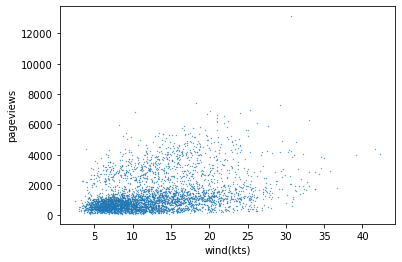

In [51]:
wind = combined_data.loc[:,'wind']
views = combined_data.loc[:,'pageviews']
plt.scatter(wind, views, s=0.1)
plt.xlabel("wind(kts)")
plt.ylabel("pageviews")
plt.show()

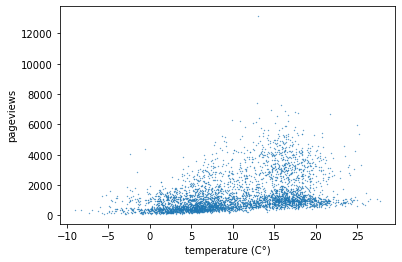

In [56]:
temp = combined_data.loc[:,'air temp']
plt.scatter(temp, views, s=0.1)
plt.xlabel("temperature (C°)")
plt.ylabel("pageviews")
plt.show()

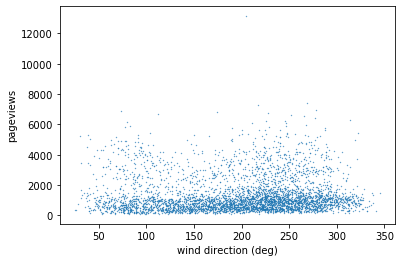

In [58]:
wind_direction = combined_data.loc[:,'wind direction']
plt.scatter(wind_direction, views, s=0.1)
plt.xlabel("wind direction (deg)")
plt.ylabel("pageviews")
plt.show()

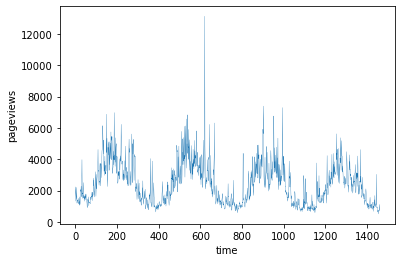

In [216]:
data_kiel = combined_data[combined_data['location'] == 1]
data_sktPeterOrding = combined_data[combined_data['location'] == 2]
data_warnemuende = combined_data[combined_data['location'] == 3]

data_kiel['pageviews'].plot(linewidth=0.3, xlabel = "time", ylabel = "pageviews");

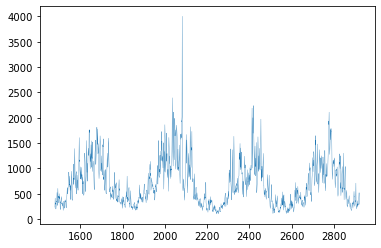

In [67]:
data_sktPeterOrding['pageviews'].plot(linewidth=0.3, xlabel = "time", ylabel = "pageviews");

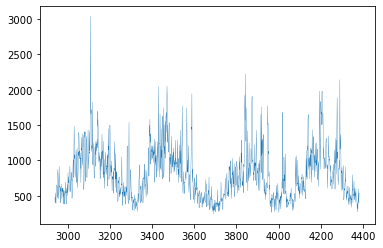

In [68]:
data_warnemuende['pageviews'].plot(linewidth=0.3, xlabel = "time", ylabel = "pageviews");

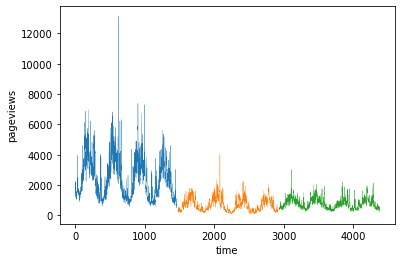

In [218]:
data_kiel['pageviews'].plot(linewidth=0.3, xlabel = "time", ylabel = "pageviews");
data_sktPeterOrding['pageviews'].plot(linewidth=0.3, xlabel = "time", ylabel = "pageviews");
data_warnemuende['pageviews'].plot(linewidth=0.3, xlabel = "time", ylabel = "pageviews");

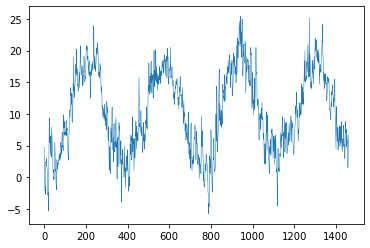

In [71]:
data_kiel['air temp'].plot(linewidth=0.5);

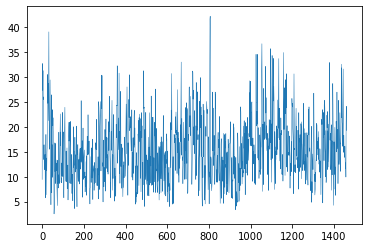

In [72]:
data_kiel['wind'].plot(linewidth=0.5);

- contradicting my expectations, the popularity of the wind finder website seems to be stable over the 4 years for which I have data. 

- as expected, both the wind speed and the temperature are positively correlated with the number of page views

- the repeating sin-like patter of the page views seems to match the repeating pattern of the air temperature. I would assume that the most important factor for the page views is the air temperature.

- the wind direction seems not to be very important for the prediction of page views


## Splitting the Data and building the model

In [192]:
X = combined_data.drop(columns=['pageviews','date', 'wind direction','wind gust'])
y = combined_data.drop(columns=['date', 'wind', 'wind direction', 'wind gust', 'air temp', 'location'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



In [193]:
print(X_train.describe())

              wind     air temp     location
count  2881.000000  2881.000000  2881.000000
mean     12.240006    10.527809     2.012149
std       5.846952     6.456361     0.814916
min       2.956522    -9.000000     1.000000
25%       7.583333     5.384615     1.000000
50%      11.041667    10.208333     2.000000
75%      15.833333    16.152778     3.000000
max      41.671329    27.708333     3.000000


In [194]:
print(X_test.describe())

              wind     air temp     location
count  1419.000000  1419.000000  1419.000000
mean     12.665607    10.104142     1.970402
std       5.996547     6.329566     0.819696
min       2.513274    -8.291667     1.000000
25%       8.031944     5.272727     1.000000
50%      11.416667     9.541667     2.000000
75%      16.104286    15.750000     3.000000
max      42.244755    26.333333     3.000000


In [195]:
# scaling the data

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



In [209]:
# building the model 

model = Sequential()
d_rate = 0.8
reg = 0
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(reg), input_shape=(3,)))  
Dropout(d_rate)
model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(reg)))
Dropout(d_rate)
model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(reg)))
Dropout(d_rate)
model.add(Dense(16,activation='relu',kernel_regularizer=regularizers.l2(reg)))
model.add(Dense(1, activation='relu'))


# Compile model
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
# Fit the model
history = model.fit(X_train, y_train, epochs=200, batch_size=100, 
                     validation_data=(X_test, y_test),
                    verbose=1)
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s:" % (model.metrics_names[1]))

Epoch 1/200
29/29 [==============================] - 1s 7ms/step - loss: 1321.8330 - mae: 1321.8330 - val_loss: 1312.9773 - val_mae: 1312.9774
Epoch 2/200
29/29 [==============================] - 0s 2ms/step - loss: 1241.4580 - mae: 1241.4580 - val_loss: 1044.0126 - val_mae: 1044.0126
Epoch 3/200
29/29 [==============================] - 0s 2ms/step - loss: 898.9895 - mae: 898.9895 - val_loss: 570.6832 - val_mae: 570.6832
Epoch 4/200
29/29 [==============================] - 0s 2ms/step - loss: 541.5541 - mae: 541.5541 - val_loss: 457.1435 - val_mae: 457.1435
Epoch 5/200
29/29 [==============================] - 0s 2ms/step - loss: 445.8793 - mae: 445.8793 - val_loss: 414.3849 - val_mae: 414.3849
Epoch 6/200
29/29 [==============================] - 0s 2ms/step - loss: 423.9984 - mae: 423.9984 - val_loss: 394.9117 - val_mae: 394.9117
Epoch 7/200
29/29 [==============================] - 0s 2ms/step - loss: 395.3664 - mae: 395.3664 - val_loss: 385.5625 - val_mae: 385.5625
Epoch 8/200
29/29 [

29/29 [==============================] - 0s 2ms/step - loss: 311.8461 - mae: 311.8461 - val_loss: 314.6604 - val_mae: 314.6604
Epoch 118/200
29/29 [==============================] - 0s 2ms/step - loss: 306.1966 - mae: 306.1966 - val_loss: 311.9359 - val_mae: 311.9359
Epoch 119/200
29/29 [==============================] - 0s 2ms/step - loss: 304.6532 - mae: 304.6532 - val_loss: 312.2290 - val_mae: 312.2290
Epoch 120/200
29/29 [==============================] - 0s 2ms/step - loss: 317.1112 - mae: 317.1112 - val_loss: 313.0789 - val_mae: 313.0789
Epoch 121/200
29/29 [==============================] - 0s 2ms/step - loss: 309.8670 - mae: 309.8670 - val_loss: 313.1803 - val_mae: 313.1803
Epoch 122/200
29/29 [==============================] - 0s 2ms/step - loss: 308.4555 - mae: 308.4556 - val_loss: 312.9465 - val_mae: 312.9465
Epoch 123/200
29/29 [==============================] - 0s 2ms/step - loss: 317.3573 - mae: 317.3573 - val_loss: 312.0298 - val_mae: 312.0298
Epoch 124/200
29/29 [======

In [210]:

model = Sequential()
d_rate = 0.8
reg = 0
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(reg), input_shape=(3,)))  
Dropout(d_rate)
model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(reg)))
Dropout(d_rate)
model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(reg)))
Dropout(d_rate)
model.add(Dense(16,activation='relu',kernel_regularizer=regularizers.l2(reg)))
model.add(Dense(1, activation='relu'))


# Compile model
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=100, 
                     validation_data=(X_test, y_test),
                    verbose=1)
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s:" % (model.metrics_names[1]))

Epoch 1/50
29/29 [==============================] - 1s 7ms/step - loss: 1311.8399 - mae: 1311.8399 - val_loss: 1315.0153 - val_mae: 1315.0153
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 1258.0613 - mae: 1258.0613 - val_loss: 1082.3937 - val_mae: 1082.3937
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 887.2685 - mae: 887.2685 - val_loss: 602.7976 - val_mae: 602.7976
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 551.9157 - mae: 551.9157 - val_loss: 472.1908 - val_mae: 472.1908
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 474.1234 - mae: 474.1234 - val_loss: 424.9754 - val_mae: 424.9754
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 448.5887 - mae: 448.5887 - val_loss: 399.6656 - val_mae: 399.6656
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 398.7947 - mae: 398.7947 - val_loss: 386.5592 - val_mae: 386.5592
Epoch 8/50
29/29 [========

In [198]:
model.evaluate(X_test, y_test)

45/45 [==============================] - 0s 484us/step - loss: 318.9459 - mae: 318.9459


[318.9458923339844, 318.9458923339844]

In [199]:
model.evaluate(X_train, y_train)

91/91 [==============================] - 0s 418us/step - loss: 326.8013 - mae: 326.8013


[326.8013000488281, 326.8013000488281]

## Comparision with Regression



In [206]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_predictions = regr.predict(X_test)
print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test, y_predictions))

Mean absolute error: 597.42


In [208]:
print(y_train.describe())

         pageviews
count  2881.000000
mean   1307.810135
std    1150.558002
min     104.000000
25%     554.000000
50%     936.000000
75%    1520.000000
max    7395.000000


## Conclusion


The mean absolute error with the neural network approach is around 318. The average value for the page views is 1307, this results in an accuracy of around 80% 1307/(1307+318) = 0.804. This result seems acceptable, and is far better than a 'basic' multivariate regression.

The factors wind direction and wind gusts did not seem to be very helpful, and removing them increased the performance. 

The model was trained with the factors wind speed, air temperature and location. A further improvement could be the inclusion of the date as an input.


